# **Import Dataset**

In [1]:
# Import the NoMercy dataset
!rm -r AMLD2021/
!git clone https://github.com/SamurAi-sarl/AMLD2021.git
!ls -ltr AMLD2021/*

Cloning into 'AMLD2021'...
remote: Enumerating objects: 6107, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 6107 (delta 2), reused 8 (delta 2), pack-reused 6098
Receiving objects: 100% (6107/6107), 432.29 MiB | 26.44 MiB/s, done.
Resolving deltas: 100% (2152/2152), done.
Checking out files: 100% (2368/2368), done.
-rw-r--r-- 1 root root    408 Sep 26 10:59 AMLD2021/README.md
-rw-r--r-- 1 root root 110453 Sep 26 10:59 AMLD2021/workshop-image.jpg

AMLD2021/dataset:
total 40
drwxr-xr-x 2 root root 20480 Sep 26 10:59 invoice
drwxr-xr-x 2 root root 20480 Sep 26 10:59 registration

AMLD2021/dataset_resized:
total 64
drwxr-xr-x 2 root root 20480 Sep 26 10:59 invoice
drwxr-xr-x 3 root root 24576 Sep 26 10:59 other
drwxr-xr-x 2 root root 20480 Sep 26 10:59 registration

AMLD2021/dataset_test:
total 1812
-rw-r--r-- 1 root root 126075 Sep 26 10:59 ex1.jpeg
-rw-r--r-- 1 root root  44561 Sep 26 10:59 ex3.jpeg
-rw-r--r-- 1 root root 14

In [59]:
print("jpeg resized images, type invoice:")
!ls AMLD2021/dataset_resized/invoice | wc -l
print("jpeg resized images, type registration:")
!ls AMLD2021/dataset_resized/registration | wc -l
print("jpeg resized images, type other:")
!ls AMLD2021/dataset_resized/other | wc -l

jpeg resized images, type invoice:
439
jpeg resized images, type registration:
419
jpeg resized images, type other:
654


# **Augmented Images**

In [82]:
# Import Augmentor (library to create more distorted images)
!pip install Augmentor
import Augmentor

# Define a function to create augmented images images
def build_augmented_images(path_folder, n_samples):
    p = Augmentor.Pipeline(path_folder)
    p.rotate(probability=0.3, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=0.5, max_factor=1.3)
    p.zoom_random(probability=0.3, percentage_area=0.8)
    p.skew_tilt(probability=0.3, magnitude=0.3)
    p.random_distortion(probability=0.3, grid_width=4, grid_height=4, magnitude=7)
    p.random_brightness(probability=0.7, min_factor=0.5, max_factor=2.)
    p.random_color(probability=0.3, min_factor=0.6, max_factor=1.4)
    p.random_contrast(probability=0.3, min_factor=0.8, max_factor=1.2)

    p.sample(n_samples, multi_threaded=True)

# Remove previous augmented images, if any (in case you run this notebook more than once) 
!rm -r AMLD2021/dataset_augmented/*
!rm -r AMLD2021/dataset_resized/invoice/output/ 
!rm -r AMLD2021/dataset_resized/registraion/output/
!rm -r AMLD2021/dataset_resized/other/output/

# Number of augmented images, per class
n = 1000   # max 1500 on colab, due to max RAM constraints

# Create augmented images
!mkdir AMLD2021/dataset_augmented/
build_augmented_images('AMLD2021/dataset_resized/invoice', n)
build_augmented_images('AMLD2021/dataset_resized/registration', n)
build_augmented_images('AMLD2021/dataset_resized/other', n)

# Move augmented images to AMLD2021/dataset_augmented/
!mv AMLD2021/dataset_resized/invoice/output      AMLD2021/dataset_augmented/invoice
!mv AMLD2021/dataset_resized/registration/output AMLD2021/dataset_augmented/registration
!mv AMLD2021/dataset_resized/other/output        AMLD2021/dataset_augmented/other

rm: cannot remove 'AMLD2021/dataset_resized/invoice/output/': No such file or directory
rm: cannot remove 'AMLD2021/dataset_resized/registraion/output/': No such file or directory
rm: cannot remove 'AMLD2021/dataset_resized/other/output/': No such file or directory
mkdir: cannot create directory ‘AMLD2021/dataset_augmented/’: File exists
Initialised with 439 image(s) found.
Output directory set to AMLD2021/dataset_resized/invoice/output.

Processing <PIL.Image.Image image mode=RGB size=500x708 at 0x7FCC43FD0ED0>: 100%|██████████| 1000/1000 [00:58<00:00, 17.01 Samples/s]


Initialised with 419 image(s) found.
Output directory set to AMLD2021/dataset_resized/registration/output.

Processing <PIL.Image.Image image mode=RGB size=500x708 at 0x7FCCC094B890>: 100%|██████████| 1000/1000 [01:00<00:00, 16.46 Samples/s]


Initialised with 654 image(s) found.
Output directory set to AMLD2021/dataset_resized/other/output.

Processing <PIL.Image.Image image mode=RGB size=500x708 at 0x7FCCBEFA2290>: 100%|██████████| 1000/1000 [01:01<00:00, 16.18 Samples/s]


In [83]:
print("Augmented resized images, type invoice")
!ls AMLD2021/dataset_augmented/invoice | wc -l
print("Augmented resized images, type registration")
!ls AMLD2021/dataset_augmented/registration | wc -l
print("Augmented resized images, type other")
!ls AMLD2021/dataset_augmented/other | wc -l

Augmented resized images, type invoice
1000
Augmented resized images, type registration
1000
Augmented resized images, type other
1000


# **Data Preparation**

In [84]:
import os

file_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")
keep_labels     = ['invoice','registration', 'other']

def list_files(indir=os.getcwd(),valid_extensions=file_extensions,valid_labels=keep_labels):
    for (rootdir,dirs,files) in os.walk(indir):
        for filename in files:
            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()
            
            # check to see if the file is an image and should be processed
            if valid_extensions is None or ext.endswith(valid_extensions):
                
                # construct the path to the image and yield it
                imagePath = os.path.join(rootdir, filename)
                
                # yield the path if the label should not be dropped 
                if imagePath.split(os.path.sep)[-2] in valid_labels:
                    yield imagePath
            
    return

###**Create Dataset**

Reading images from disk. This may take a while ... 


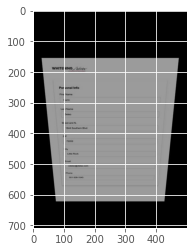

Original Image
---------------------


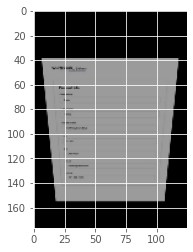

Resized Image
---------------------


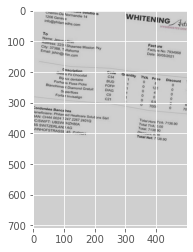

Original Image
---------------------


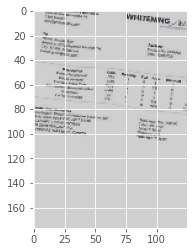

Resized Image
---------------------


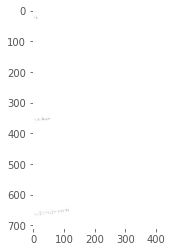

Original Image
---------------------


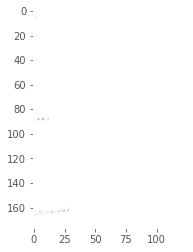

Resized Image
---------------------


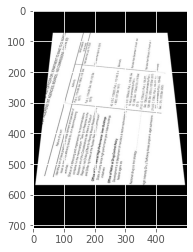

Original Image
---------------------


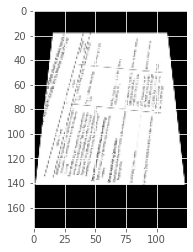

Resized Image
---------------------


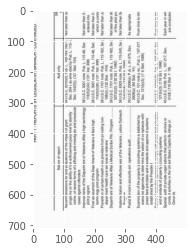

Original Image
---------------------


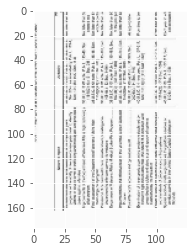

Resized Image
---------------------


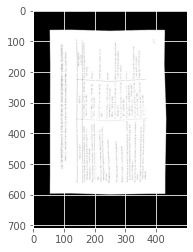

Original Image
---------------------


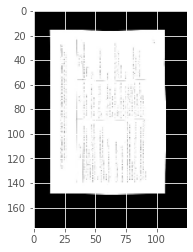

Resized Image
---------------------


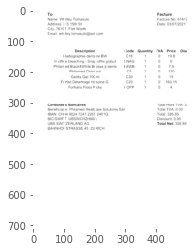

Original Image
---------------------


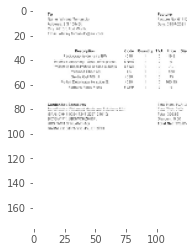

Resized Image
---------------------


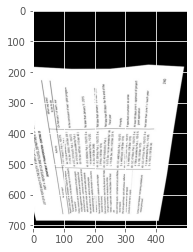

Original Image
---------------------


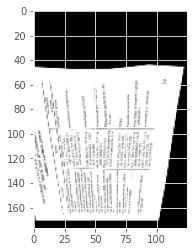

Resized Image
---------------------


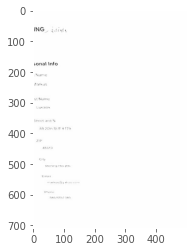

Original Image
---------------------


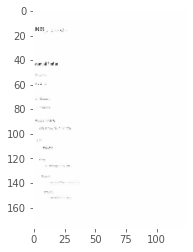

Resized Image
---------------------
1000 images imported
2000 images imported
3000 images imported
---------------------
label: other counts: 1000
label: invoice counts: 1000
label: registration counts: 1000


In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
import random
import cv2


dataset_path = 'AMLD2021/dataset_augmented/'
    
# obtain image paths and ramdomize it
image_paths = list(list_files(dataset_path))
random.seed(42)
random.shuffle(image_paths)
    
# initialize data and labels list
data, labels, count = [],[],0

# resize
RESIZE = 125, 177 
#RESIZE = 83, 118 

print("Reading images from disk. This may take a while ... ")    
for i in image_paths:

    # get image label from parent folder name
    label = i.split(os.path.sep)[-2]
    
    # count images processes and append list with labels
    count+=1
    labels.append(label)

    # load the image and store the image in the data list
    image = cv2.imread(i)
    image = cv2.resize(image, RESIZE)
    data.append(image)

    # show first 5 images before and after resizing
    if count < 10:
      img = io.imread(i)
      plt.imshow(img)
      plt.show()
      print("Original Image")
      print("---------------------")
      plt.imshow(image)
      plt.show()
      print("Resized Image")
      print("---------------------")
    
    # show progress
    if ((count % 1000) == 0):
      print( str(count) + " images imported")

# print label count
label_list = os.listdir(dataset_path)
print("---------------------")
for l in label_list: print("label: {} counts: {}".format(l,labels.count(l)))

In [86]:
print("Size of imported X dataset: " + str(len(data)))
print("Size of imported y dataset: " + str(len(labels)))

Size of imported X dataset: 3000
Size of imported y dataset: 3000


###**Train-Test Split**

In [87]:
import numpy as np
from sklearn.model_selection import train_test_split

# convert to np arrays
data = np.array(data,dtype="float")
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

###**One Hot-Encoding**

In [88]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

original_classes = trainY
    
# integer encode
label_encoder = LabelEncoder()
trainY = label_encoder.fit_transform(trainY)
testY  = label_encoder.transform(testY)
    
print(original_classes[0:10])
#print(trainY[0:10])
u, indices = np.unique(trainY, return_index=True)
classes = [original_classes[i] for i in indices]
#print(classes)
  
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
trainY = trainY.reshape(len(trainY), 1)
trainY = onehot_encoder.fit_transform(trainY)
testY = testY.reshape(len(testY), 1)
testY = onehot_encoder.transform(testY)
print(trainY[0:10])

['invoice' 'other' 'invoice' 'other' 'other' 'registration' 'other'
 'other' 'other' 'registration']
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# **Define Model and Compile**

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dropout

In [90]:
INPUT_DROPOUT = 0.0
CONV_DROPOUT = 0.2
DENSE_DROPOUT = 0.2

headmodel = Sequential()

# Input dropout
headmodel.add(Dropout(INPUT_DROPOUT, input_shape=(RESIZE[1], RESIZE[0], 3)))

# Convolutional Layer 1
headmodel.add(Conv2D(8, (5, 5), padding='same', activation='relu'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 4
headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
headmodel.add(Dropout(CONV_DROPOUT))
headmodel.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 6
#headmodel.add(Conv2D(4, (3, 3), activation='relu', padding='same'))
#headmodel.add(Dropout(CONV_DROPOUT))
#headmodel.add(MaxPooling2D(pool_size=(2, 2)))

headmodel.add(Flatten())

# Dense Layer 1
headmodel.add(Dense(100, activation='relu'))
headmodel.add(Dropout(DENSE_DROPOUT))

# Dense Layer 2
#headmodel.add(Dense(100, activation='relu'))
#headmodel.add(Dropout(DENSE_DROPOUT))

ACTIVATION = 'softmax'   # 'sigmoid'
headmodel.add(Dense(len(classes), activation=ACTIVATION))


#compiling the model
print("Compiling model...")
opt = Adam()
#opt = SGD()
headmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

headmodel.summary()

Compiling model...
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_106 (Dropout)        (None, 177, 125, 3)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 177, 125, 8)       608       
_________________________________________________________________
dropout_107 (Dropout)        (None, 177, 125, 8)       0         
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 88, 62, 8)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 88, 62, 4)         292       
_________________________________________________________________
dropout_108 (Dropout)        (None, 88, 62, 4)         0         
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None

##**Train Model**

In [91]:
# define early stopping callback
callback= EarlyStopping(
          monitor="val_loss",
          patience=20,
          mode="auto",
          restore_best_weights=True,
          )

# initialize # of epochs and batch size
EPOCHS = 200
BS = 32

# train the network
H = headmodel.fit(trainX, trainY, 
                  validation_data=(testX, testY), 
                  epochs=EPOCHS, 
                  batch_size=BS, 
                  callbacks = [callback],)

Epoch 1/200
71/71 [==============================] - 4s 37ms/step - loss: 4.4265 - accuracy: 0.3284 - val_loss: 1.1183 - val_accuracy: 0.3120
Epoch 2/200
71/71 [==============================] - 2s 29ms/step - loss: 1.2103 - accuracy: 0.3307 - val_loss: 1.1078 - val_accuracy: 0.3160
Epoch 3/200
71/71 [==============================] - 2s 28ms/step - loss: 1.1457 - accuracy: 0.3373 - val_loss: 1.1038 - val_accuracy: 0.3240
Epoch 4/200
71/71 [==============================] - 2s 28ms/step - loss: 1.1276 - accuracy: 0.3404 - val_loss: 1.1042 - val_accuracy: 0.3227
Epoch 5/200
71/71 [==============================] - 2s 29ms/step - loss: 1.1207 - accuracy: 0.3369 - val_loss: 1.1035 - val_accuracy: 0.3133
Epoch 6/200
71/71 [==============================] - 2s 29ms/step - loss: 1.1092 - accuracy: 0.3409 - val_loss: 1.1029 - val_accuracy: 0.3173
Epoch 7/200
71/71 [==============================] - 2s 29ms/step - loss: 1.1106 - accuracy: 0.3440 - val_loss: 1.1031 - val_accuracy: 0.3240
Epoch 

##**Evaluate the Network**

Evaluating network...
              precision    recall  f1-score   support

     invoice       1.00      1.00      1.00       236
       other       1.00      0.99      1.00       236
registration       0.99      1.00      1.00       278

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



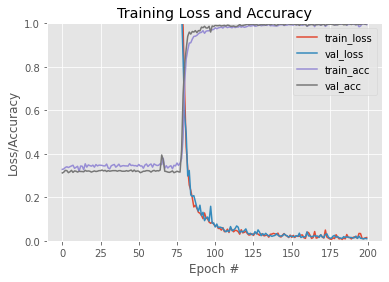

In [92]:
import matplotlib
matplotlib.use("Agg")

# evaluate the network
print("Evaluating network...")
predictions = headmodel.predict(x=testX)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=classes))
    
# plot the training loss and accuracy
N = np.arange(0, len(H.history["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

['AMLD2021/dataset_test/ex1.jpeg', 'AMLD2021/dataset_test/ex4.jpeg', 'AMLD2021/dataset_test/ex5.jpeg', 'AMLD2021/dataset_test/ex2.jpeg', 'AMLD2021/dataset_test/ex6.jpeg', 'AMLD2021/dataset_test/ex3.jpeg', 'AMLD2021/dataset_test/ex7.jpeg']
[INFO] Reading images from disk. This may take a while ... 


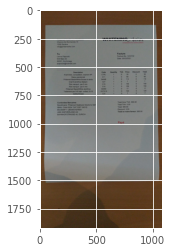

Prob. Invoice:      0.9951192
Prob. Other:        0.0048801927
Prob. Registration: 6.1164604e-07
Uploaded Image: AMLD2021/dataset_test/ex1.jpeg
---------------------


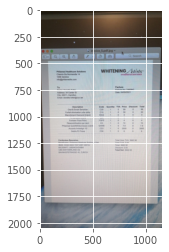

Prob. Invoice:      0.0016603994
Prob. Other:        0.9982597
Prob. Registration: 7.987912e-05
Uploaded Image: AMLD2021/dataset_test/ex4.jpeg
---------------------


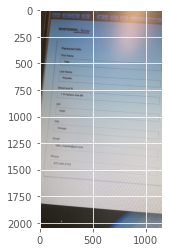

Prob. Invoice:      0.00073468615
Prob. Other:        0.27146167
Prob. Registration: 0.72780365
Uploaded Image: AMLD2021/dataset_test/ex5.jpeg
---------------------


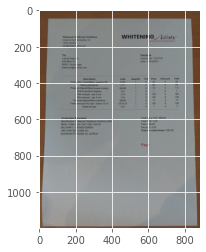

Prob. Invoice:      0.9787136
Prob. Other:        0.021286316
Prob. Registration: 1.496542e-07
Uploaded Image: AMLD2021/dataset_test/ex2.jpeg
---------------------


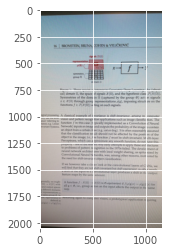

Prob. Invoice:      9.831962e-05
Prob. Other:        0.99979633
Prob. Registration: 0.000105381216
Uploaded Image: AMLD2021/dataset_test/ex6.jpeg
---------------------


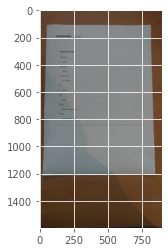

Prob. Invoice:      1.4960776e-06
Prob. Other:        0.0017720193
Prob. Registration: 0.99822646
Uploaded Image: AMLD2021/dataset_test/ex3.jpeg
---------------------


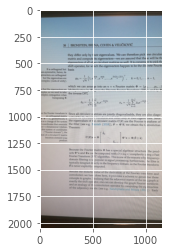

Prob. Invoice:      1.9158502e-08
Prob. Other:        1.0
Prob. Registration: 5.283278e-08
Uploaded Image: AMLD2021/dataset_test/ex7.jpeg
---------------------


In [93]:
%matplotlib inline
upload_path = 'AMLD2021/dataset_test/'

def list_files_test(indir=os.getcwd()):
    for (rootdir,dirs,files) in os.walk(indir):
        for filename in files:
            yield upload_path + filename

uploadX = list(list_files_test(upload_path))
print(uploadX)



print("[INFO] Reading images from disk. This may take a while ... ")    
for i in uploadX:
    # show image
    img = io.imread(i)
    plt.imshow(img)
    plt.show()

    # load the image and store the image in the data list
    image = cv2.imread(i)
    image = cv2.resize(image, RESIZE)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    pred = headmodel.predict(image)
    print("Prob. Invoice:      " + str(pred[0][0]))
    print("Prob. Other:        " + str(pred[0][1]))
    print("Prob. Registration: " + str(pred[0][2]))
    print("Uploaded Image: " + i)
    print("---------------------")

In [94]:
# TO BE CLEANED
!cp AMLD2021/dataset_test/ex1.jpeg AMLD2021/dataset_test/ex2.jpeg AMLD2021/dataset_test/ex4.jpeg AMLD2021/dataset_resized/invoice/
!cp AMLD2021/dataset_test/ex3.jpeg AMLD2021/dataset_test/ex5.jpeg AMLD2021/dataset_resized/registration/
!cp AMLD2021/dataset_test/ex6.jpeg AMLD2021/dataset_test/ex7.jpeg AMLD2021/dataset_resized/other/
